## 1. Data Preparation 

### 1.1 Libraries and Imports 

In [64]:
# 1. System/Environment Imports
import os
import sys
import re
import random
import time
import math
import json
from collections import Counter

# 2. Data Analysis and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Progress and Logging
from tqdm.notebook import tqdm  # or just 'tqdm' if you prefer
import logging

# 4. NLTK for Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 5. Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline

# 6. PyTorch
import torch
import torch.nn as nn
from torch.utils.data import (DataLoader, 
                              TensorDataset, 
                              RandomSampler, 
                              SequentialSampler)

# 7. Hugging Face Transformers & Datasets
from transformers import (DistilBertTokenizer, 
                          DistilBertForSequenceClassification,
                          AdamW, 
                          get_linear_schedule_with_warmup)
from datasets import load_dataset, Dataset

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


# 8. Visualization / Notebook Settings
%matplotlib inline
plt.style.use('ggplot')
sns.set(style='whitegrid')

# 9. Device Configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# 10. Seed Setting for Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/malorieiovino/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/malorieiovino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/malorieiovino/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: mps


----

### 1.2 Data Exploration & Understanding 

In [66]:
from datasets import load_dataset 
fever_dataset = load_dataset("fever", "v1.0")
print("Keys in train split:", fever_dataset["train"][0].keys())
print(f"Train set size: {len(fever_dataset['train'])}")

Keys in train split: dict_keys(['id', 'label', 'claim', 'evidence_annotation_id', 'evidence_id', 'evidence_wiki_url', 'evidence_sentence_id'])
Train set size: 311431


In [68]:
fever_dataset["train"] [0:5]

{'id': [75397, 75397, 150448, 150448, 214861],
 'label': ['SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS', 'SUPPORTS'],
 'claim': ['Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'Roman Atwood is a content creator.',
  'Roman Atwood is a content creator.',
  'History of art includes architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.'],
 'evidence_annotation_id': [92206, 92206, 174271, 174271, 255136],
 'evidence_id': [104971, 104971, 187498, 187499, 254645],
 'evidence_wiki_url': ['Nikolaj_Coster-Waldau',
  'Fox_Broadcasting_Company',
  'Roman_Atwood',
  'Roman_Atwood',
  'History_of_art'],
 'evidence_sentence_id': [7, -1, 1, 3, 2]}

In [70]:
list(fever_dataset["train"] [0].keys())

['id',
 'label',
 'claim',
 'evidence_annotation_id',
 'evidence_id',
 'evidence_wiki_url',
 'evidence_sentence_id']

In [72]:
#Glance 
example_item = fever_dataset["train"][0]
print("Example item:\n", example_item)

Example item:
 {'id': 75397, 'label': 'SUPPORTS', 'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.', 'evidence_annotation_id': 92206, 'evidence_id': 104971, 'evidence_wiki_url': 'Nikolaj_Coster-Waldau', 'evidence_sentence_id': 7}


### 1.3 Data Loading & Preprocessing 

In [74]:
#preprocessing
def preprocess_text(text):
    text = text.lower() #lowercase
    text = re.sub(r'[^\w\s]', '', text) #remove special chars
    tokens = text.split() #tokenization 
    
    stop_words = set(stopwords.words('english')) #stopword removal
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer() #lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# preprocessing subset of claims
processed_claims = []
for i in range(1000):  # Process first 1000 examples
    item = fever_dataset['train'][i]
    processed_claims.append(preprocess_text(item['claim']))

# a few examples
for i in range(5):
    print(f"Original: {fever_dataset['train'][i]['claim']}")
    print(f"Processed: {processed_claims[i]}")
    print(f"Label: {fever_dataset['train'][i]['label']}")
    print("---")

Original: Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
Processed: nikolaj costerwaldau worked fox broadcasting company
Label: SUPPORTS
---
Original: Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
Processed: nikolaj costerwaldau worked fox broadcasting company
Label: SUPPORTS
---
Original: Roman Atwood is a content creator.
Processed: roman atwood content creator
Label: SUPPORTS
---
Original: Roman Atwood is a content creator.
Processed: roman atwood content creator
Label: SUPPORTS
---
Original: History of art includes architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.
Processed: history art includes architecture dance sculpture music painting poetry literature theatre narrative film photography graphic art
Label: SUPPORTS
---


---

## 2. Initial Model Development

In [76]:
#loading
subset_size = 50000 
clean_dataset = []

for i in range(min(subset_size, len(fever_dataset['train']))):
    item = fever_dataset['train'][i]
    # Skip items without 'claim' or 'label'
    if not all(k in item for k in ['claim', 'label']):
        continue
    
    clean_item = {
        'original_claim': item['claim'],
        'processed_claim': preprocess_text(item['claim']),
        'label': item['label'],
        'id': item['id']
    }
    clean_dataset.append(clean_item)

df_clean = pd.DataFrame(clean_dataset)
print(f"Total cleaned examples: {len(df_clean)}")

#label distribution
print("\nLabel distribution:")
print(df_clean['label'].value_counts())

df_clean.to_csv('clean_fever_dataset.csv', index=False)
print("\nCleaned dataset saved to 'clean_fever_dataset.csv'")


Total cleaned examples: 50000

Label distribution:
label
SUPPORTS           31131
REFUTES            11104
NOT ENOUGH INFO     7765
Name: count, dtype: int64

Cleaned dataset saved to 'clean_fever_dataset.csv'


## 3. Advanced Model Development 

### 3.1 Train/Val/Test Split & DataLoader Creation 

In [27]:
df_fever = pd.read_csv('clean_fever_dataset.csv')

# Map labels to numeric IDs
label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT ENOUGH INFO': 2}
if df_fever['label'].dtype == object:
    df_fever['label_id'] = df_fever['label'].map(label_map)
else:
    df_fever['label_id'] = df_fever['label']

# Split the dataset into train, validation, and test sets
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df_fever, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# Create a helper function to convert text and labels to a PyTorch dataset
def create_dataset(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    labels = torch.tensor(labels)
    from torch.utils.data import TensorDataset
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
    return dataset

text_column = 'processed_claim' if 'processed_claim' in df_fever.columns else 'claim'

# dataset creation
train_dataset = create_dataset(train_df[text_column].tolist(), train_df['label_id'].tolist(), tokenizer)
val_dataset   = create_dataset(val_df[text_column].tolist(),   val_df['label_id'].tolist(),   tokenizer)
test_dataset  = create_dataset(test_df[text_column].tolist(),  test_df['label_id'].tolist(),  tokenizer)

# dataloader creation
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader   = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader  = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)


Train: 40000, Validation: 5000, Test: 5000


## 4. Pre-Trained Models

In [34]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Load the model with the correct number of labels (3 in this case)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### 4.1 Training Function & Loss Setup 

In [40]:
def train_model(model, train_dataloader, val_dataloader, epochs=3, lr=5e-5):
    import torch.nn as nn
    from transformers import AdamW, get_linear_schedule_with_warmup
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np
    from tqdm.notebook import tqdm  # Import tqdm for a nice progress bar

    # Compute class weights using the full dataset labels
    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(df_fever['label_id']), 
        y=df_fever['label_id']
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        train_loss = 0

        # Wrap the training dataloader with tqdm for a progress bar
        for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", leave=False):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            model.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            train_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        
        avg_train_loss = train_loss / len(train_dataloader)
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Validation step: Evaluate on the validation dataloader
        val_loss, val_acc = evaluate_model(model, val_dataloader, compute_acc=True)
        print(f"Validation loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        
        # Save the best model state based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model


### 4.2 Training & Test Evaluation 

In [42]:
#Training the model 
epochs = 3
print("Starting training...")
trained_model = train_model(model, train_dataloader, val_dataloader, epochs=epochs, lr=5e-5)

# Evaluate on test set
test_loss, test_acc = evaluate_model(trained_model, test_dataloader, compute_acc=True)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Generate detailed predictions for classification report
from sklearn.metrics import classification_report
all_preds, all_labels = [], []
trained_model.eval()

from tqdm.notebook import tqdm  # or import it at the top if you prefer

with torch.no_grad():
    # Wrap the test_dataloader with tqdm for a progress bar
    for batch in tqdm(test_dataloader, desc="Generating Predictions", leave=False):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = trained_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))


Starting training...

Epoch 1/3


/opt/anaconda3/lib/python3.12/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1:   0%|          | 0/2500 [00:00<?, ?it/s]

Average training loss: 0.5808
Validation loss: 0.5287, Accuracy: 0.8002

Epoch 2/3


Training Epoch 2:   0%|          | 0/2500 [00:00<?, ?it/s]

Average training loss: 0.3373
Validation loss: 0.5287, Accuracy: 0.8308

Epoch 3/3


Training Epoch 3:   0%|          | 0/2500 [00:00<?, ?it/s]

Average training loss: 0.1874
Validation loss: 0.7269, Accuracy: 0.8424
Test Loss: 0.7389, Test Accuracy: 0.8394


Generating Predictions:   0%|          | 0/313 [00:00<?, ?it/s]


Classification Report:
                 precision    recall  f1-score   support

       SUPPORTS       0.88      0.91      0.89      3095
        REFUTES       0.82      0.79      0.80      1133
NOT ENOUGH INFO       0.69      0.63      0.66       772

       accuracy                           0.84      5000
      macro avg       0.80      0.78      0.79      5000
   weighted avg       0.84      0.84      0.84      5000



---

### 4.3 Setup, Model Loading, and Data Splitting

In [46]:
# Setup & Model Loading 
import nltk
try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger')

# Import any additional libraries you need here
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Define device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Check if a model is already in memory
if 'trained_model' in locals() or 'trained_model' in globals():
    print("Using existing trained_model from memory.")
else:
    print("No trained_model in memory; loading from pretrained.")
    # Load DistilBert model
    trained_model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=3
    )
    trained_model.to(device)

# Define label maps
label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT ENOUGH INFO': 2}
id_to_label = {v: k for k, v in label_map.items()}

# Check if tokenizer is in memory
if 'tokenizer' in locals() or 'tokenizer' in globals():
    print("Using existing tokenizer from memory.")
else:
    print("No tokenizer in memory; loading DistilBert tokenizer.")
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


Using device: mps
Using existing trained_model from memory.
Using existing tokenizer from memory.


In [50]:
# Data Loading & Splitting 
import pandas as pd
from sklearn.model_selection import train_test_split

df_fever = pd.read_csv('clean_fever_dataset.csv')
print(f"Loaded dataset with {len(df_fever)} samples.")

label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT ENOUGH INFO': 2}
if 'label_id' not in df_fever.columns:
    df_fever['label_id'] = df_fever['label'].map(label_map)

train_df, temp_df = train_test_split(df_fever, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Using existing text with {len(train_df)} train, {len(val_df)} val, {len(test_df)} test samples.")

Loaded dataset with 50000 samples.
Using existing text with 40000 train, 5000 val, 5000 test samples.


---

## 5. Confusion Matrix

Creating 'results_df' with predictions...

Using 'processed_claim' column for predictions...
Generating predictions...


Predicting:   0%|          | 0/313 [00:00<?, ?it/s]


Analyzing results_df...

Class distribution in test set:
label
SUPPORTS           3095
REFUTES            1133
NOT ENOUGH INFO     772
Name: count, dtype: int64

Accuracy: 0.8394


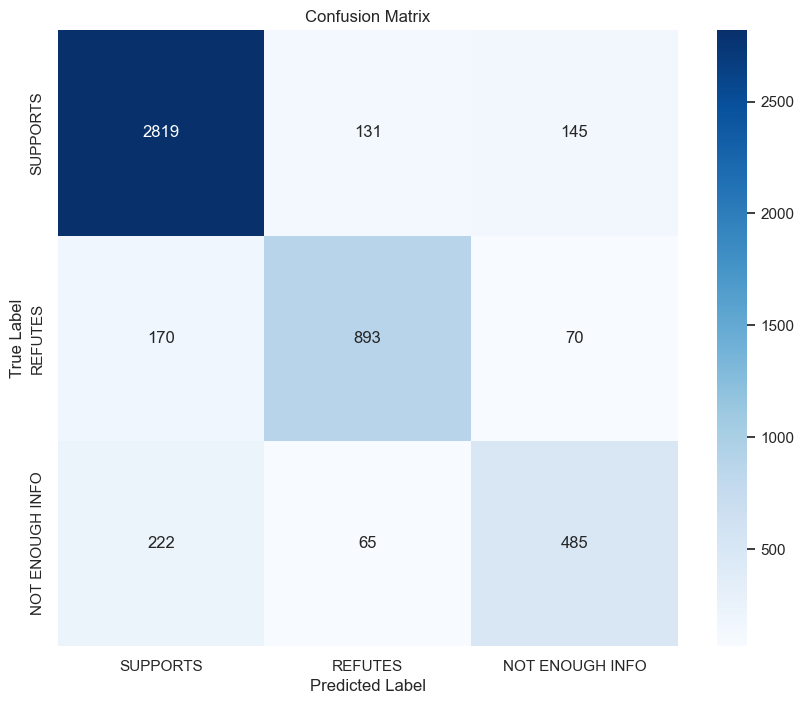


Classification Report:
                 precision    recall  f1-score   support

       SUPPORTS       0.88      0.91      0.89      3095
        REFUTES       0.82      0.79      0.80      1133
NOT ENOUGH INFO       0.69      0.63      0.66       772

       accuracy                           0.84      5000
      macro avg       0.80      0.78      0.79      5000
   weighted avg       0.84      0.84      0.84      5000



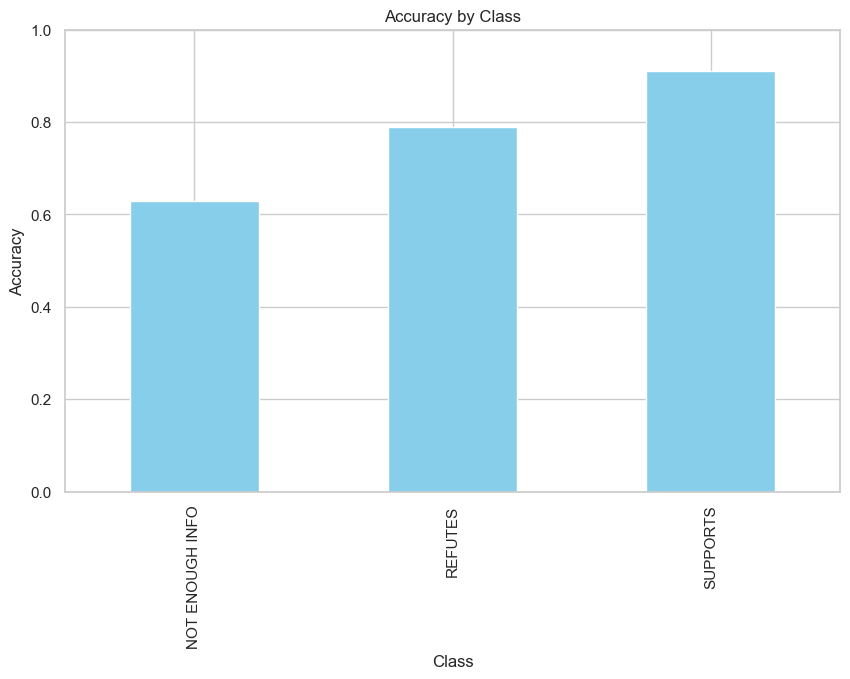

In [92]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm

def generate_predictions(model, df, tokenizer, batch_size=16):
    text_col = "processed_claim" if "processed_claim" in df.columns else "original_claim"
    print(f"Using '{text_col}' column for predictions...")

    encodings = tokenizer(
        df[text_col].tolist(),
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )
    
    labels = torch.tensor(df["label_id"].tolist())  # ensure 'label_id' exists
    dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"], labels)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    print("Generating predictions...")
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting", leave=False):
            input_ids, attention_mask, batch_labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(batch_labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    df_copy = df.copy()
    inv_label_map = {v: k for k, v in label_map.items()}
    
    df_copy["predicted_label_id"] = all_preds
    df_copy["predicted_label"] = [inv_label_map[p] for p in all_preds]
    df_copy["is_correct"] = df_copy["label_id"] == df_copy["predicted_label_id"]

    # Confidence for each prediction
    conf_list = []
    for prob_arr, pred_id in zip(all_probs, all_preds):
        conf_list.append(prob_arr[pred_id])
    df_copy["prediction_confidence"] = conf_list
    
    return df_copy


def confusion_matrix_analysis(results_df):
    """
    Displays class distribution, overall accuracy, confusion matrix,
    classification report, and a bar plot of accuracy by class.
    """
    print("Class distribution in test set:")
    print(results_df["label"].value_counts())
    print(f"\nAccuracy: {results_df['is_correct'].mean():.4f}")

    # Confusion matrix
    cm = confusion_matrix(results_df["label_id"], results_df["predicted_label_id"])
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap="Blues",
        xticklabels=id_to_label.values(),
        yticklabels=id_to_label.values()
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(
        results_df["label_id"],
        results_df["predicted_label_id"],
        target_names=id_to_label.values()
    ))

    # Accuracy by class
    class_accuracy = results_df.groupby("label")["is_correct"].mean().sort_values()
    plt.figure(figsize=(10, 6))
    class_accuracy.plot(kind='bar', color='skyblue')
    plt.title("Accuracy by Class")
    plt.ylabel("Accuracy")
    plt.xlabel("Class")
    plt.ylim(0, 1)
    plt.show()

print("Creating 'results_df' with predictions...\n")
results_df = generate_predictions(trained_model, test_df, tokenizer, batch_size=16)

print("\nAnalyzing results_df...\n")
confusion_matrix_analysis(results_df)


----

### 5.1 Text Length Analysis 


Index(['original_claim', 'processed_claim', 'label', 'id', 'label_id',
       'predicted_label_id', 'predicted_label', 'is_correct',
       'prediction_confidence'],
      dtype='object')
Calling text_length_analysis now...
Accuracy by Length Bin:
length_bin
0-5      0.897083
6-10     0.829421
11-15    0.779687
16-20    0.819277
21-25    0.777778
26-30    0.750000
31+      0.800000
Name: is_correct, dtype: float64


/var/folders/3l/w80bwjn10s31hnw03zfvlhxc0000gn/T/ipykernel_40611/2144207475.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_accuracy = results_df.groupby('length_bin')['is_correct'].mean()
/var/folders/3l/w80bwjn10s31hnw03zfvlhxc0000gn/T/ipykernel_40611/2144207475.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_counts = results_df.groupby('length_bin').size()


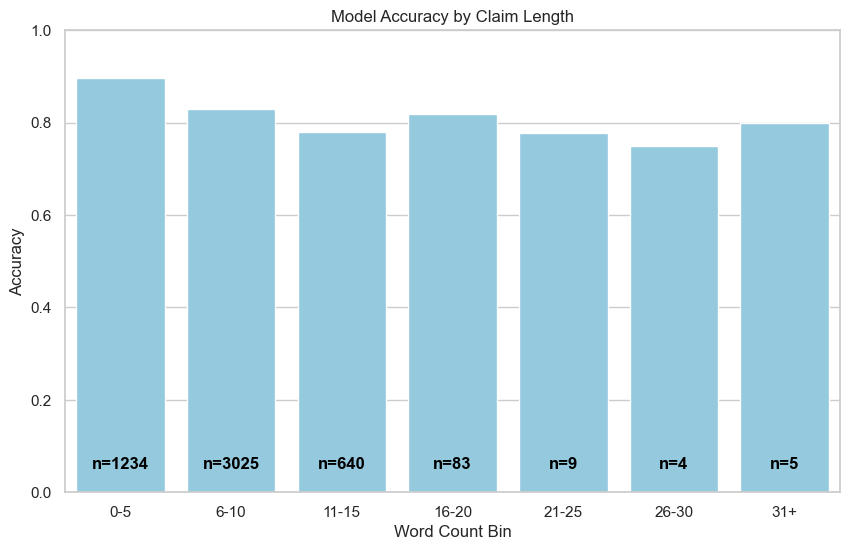

In [99]:
%matplotlib inline

print(results_df.columns)
if 'word_count' not in results_df.columns:
    results_df['word_count'] = results_df['original_claim'].apply(lambda x: len(str(x).split()))
if 'is_correct' not in results_df.columns:
    results_df['is_correct'] = results_df['label_id'] == results_df['predicted_label_id']

def text_length_analysis(results_df):
    """
    Analyze how text length affects model performance.
    """
    # Bin the word counts
    results_df['length_bin'] = pd.cut(
        results_df['word_count'],
        bins=[0,5,10,15,20,25,30,100],
        labels=['0-5','6-10','11-15','16-20','21-25','26-30','31+']
    )
    # Accuracy by bin
    length_accuracy = results_df.groupby('length_bin')['is_correct'].mean()
    length_counts = results_df.groupby('length_bin').size()

    print("Accuracy by Length Bin:")
    print(length_accuracy)

    # Bar plot
    plt.figure(figsize=(10,6))
    sns.barplot(x=length_accuracy.index, y=length_accuracy.values, color='skyblue')
    plt.title("Model Accuracy by Claim Length")
    plt.ylabel("Accuracy")
    plt.xlabel("Word Count Bin")
    plt.ylim(0,1)
    for i, v in enumerate(length_counts):
        plt.text(i, 0.05, f"n={v}", ha='center', color='black', fontweight='bold')
    plt.show()

print("Calling text_length_analysis now...")
text_length_analysis(results_df)


----

### 5.2 Evaluation 

Extracting topics from a sample of 1000 claims...
Most common topics: ['film', 'actor', 'series', 'album', 'person', 'television', 'movie', 'star', 'state', 'show']


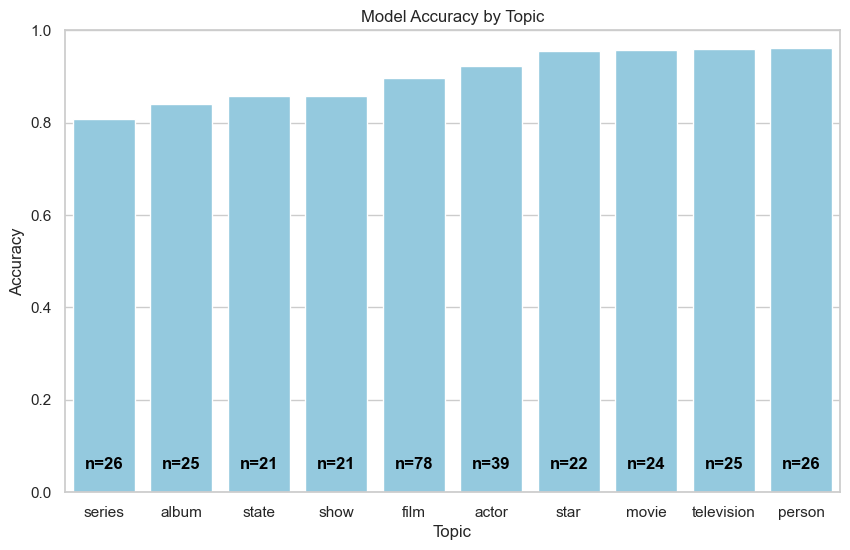


Class distribution within topics:

Topic: series (n=26)
label
SUPPORTS           0.615385
NOT ENOUGH INFO    0.192308
REFUTES            0.192308
Name: proportion, dtype: float64

Topic: album (n=25)
label
SUPPORTS           0.72
REFUTES            0.24
NOT ENOUGH INFO    0.04
Name: proportion, dtype: float64

Topic: state (n=21)
label
SUPPORTS           0.714286
REFUTES            0.190476
NOT ENOUGH INFO    0.095238
Name: proportion, dtype: float64

Topic: show (n=21)
label
SUPPORTS           0.714286
REFUTES            0.238095
NOT ENOUGH INFO    0.047619
Name: proportion, dtype: float64

Topic: film (n=78)
label
SUPPORTS           0.692308
REFUTES            0.179487
NOT ENOUGH INFO    0.128205
Name: proportion, dtype: float64

Topic: actor (n=39)
label
SUPPORTS           0.666667
REFUTES            0.230769
NOT ENOUGH INFO    0.102564
Name: proportion, dtype: float64

Topic: star (n=22)
label
SUPPORTS           0.681818
NOT ENOUGH INFO    0.181818
REFUTES            0.136364
Name

In [268]:
from collections import Counter

def topic_entity_analysis(results_df, sample_size=1000):
    text_col = "processed_claim" if "processed_claim" in results_df.columns else "original_claim"
    sample_size = min(sample_size, len(results_df))
    topic_df = results_df.sample(sample_size, random_state=42).copy()

    print(f"Extracting topics from a sample of {sample_size} claims...")

    def extract_topics(text):
        tokens = word_tokenize(text.lower())
        tagged = pos_tag(tokens)
        nouns = [word for (word, tag) in tagged if tag.startswith('NN')]
        return nouns

    topic_df['topics'] = topic_df[text_col].apply(extract_topics)

    all_topics = [t for sublist in topic_df['topics'] for t in sublist]
    common_topics = [word for (word, count) in Counter(all_topics).most_common(10)]
    print(f"Most common topics: {common_topics}")

    for t in common_topics:
        topic_df[f'contains_{t}'] = topic_df['topics'].apply(lambda x: t in x)

    topic_accuracy = {}
    topic_counts = {}
    for t in common_topics:
        subset = topic_df[topic_df[f'contains_{t}']]
        n = len(subset)
        if n > 20:
            acc = subset['is_correct'].mean()
            topic_accuracy[t] = acc
            topic_counts[t] = n

    if topic_accuracy:
        plt.figure(figsize=(10, 6))
        sorted_topics = sorted(topic_accuracy.keys(), key=lambda k: topic_accuracy[k])
        sorted_acc = [topic_accuracy[t] for t in sorted_topics]
        sns.barplot(x=sorted_topics, y=sorted_acc, color='skyblue')
        plt.title("Model Accuracy by Topic")
        plt.ylabel("Accuracy")
        plt.xlabel("Topic")
        plt.ylim(0, 1)
        for i, t in enumerate(sorted_topics):
            plt.text(i, 0.05, f"n={topic_counts[t]}", ha='center', color='black', fontweight='bold')
        plt.show()

        print("\nClass distribution within topics:")
        for t in sorted_topics:
            subset = topic_df[topic_df[f'contains_{t}']]
            if len(subset) > 20 and 'label' in subset.columns:
                print(f"\nTopic: {t} (n={len(subset)})")
                print(subset['label'].value_counts(normalize=True))

    return topic_df

# -- ACTUALLY CALL THE FUNCTION --
topic_results = topic_entity_analysis(results_df, sample_size=1000)
 


---

### 5.3 Confidence Analysis 

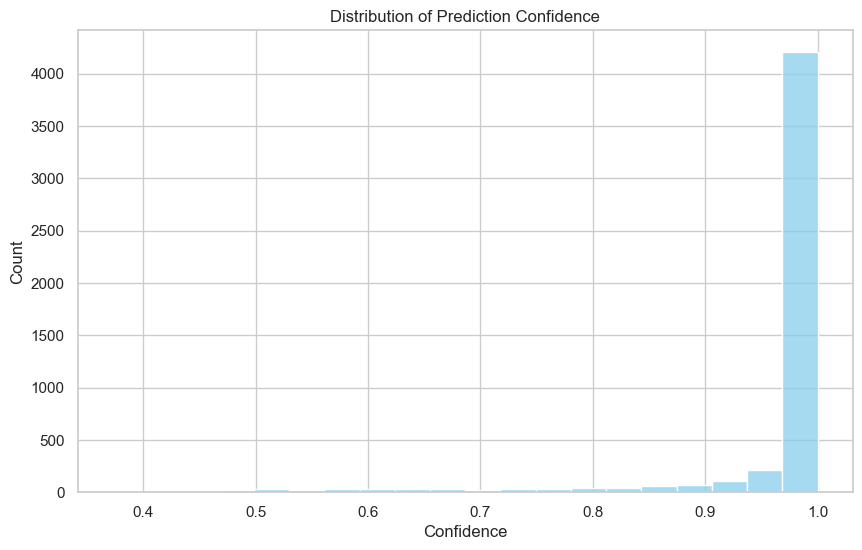

/var/folders/3l/w80bwjn10s31hnw03zfvlhxc0000gn/T/ipykernel_40611/3851190396.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_correct', y='prediction_confidence', data=results_df, palette='Set2')


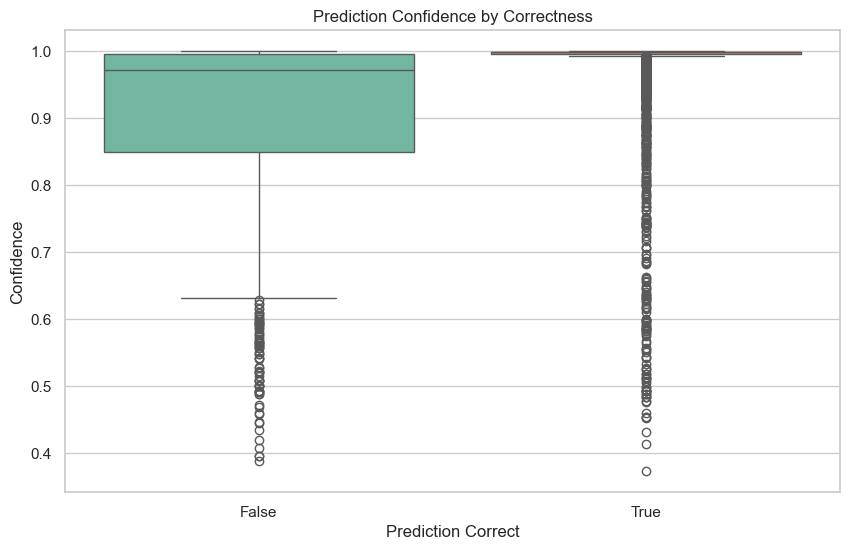

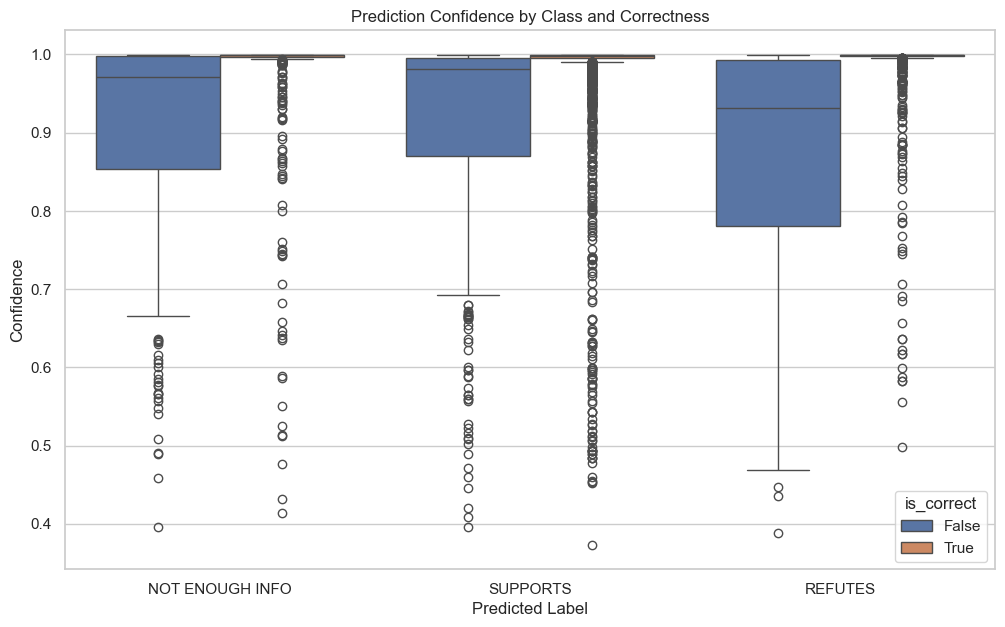

/var/folders/3l/w80bwjn10s31hnw03zfvlhxc0000gn/T/ipykernel_40611/3851190396.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal_df = results_df.groupby('conf_bin')['is_correct'].mean().reset_index()
/var/folders/3l/w80bwjn10s31hnw03zfvlhxc0000gn/T/ipykernel_40611/3851190396.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = results_df.groupby('conf_bin').size().values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite valu

Number of high-confidence (>0.9) incorrect predictions: 550
This is 11.00% of all predictions


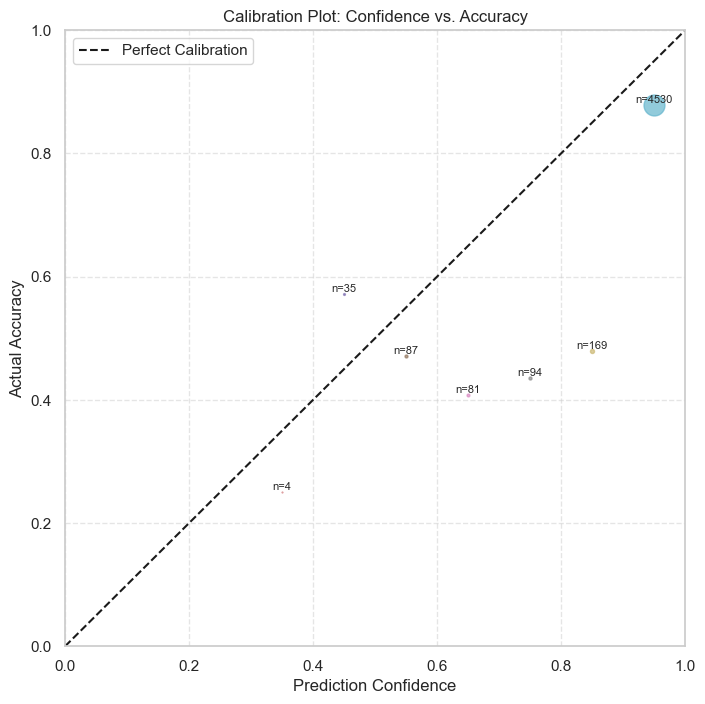

Expected Calibration Error (ECE): nan


In [109]:
def confidence_analysis(results_df):
    """
    Analyze model confidence across predictions.

    Steps:
      1. Plot histogram of 'prediction_confidence'
      2. Compare confidence for correct vs. incorrect predictions (boxplot)
      3. Compare confidence by predicted class and correctness (boxplot)
      4. Identify high-confidence (>0.9) incorrect predictions
      5. Plot a calibration curve (confidence vs. actual accuracy) and compute ECE
    
    Expects:
      - results_df['prediction_confidence']: float confidence scores
      - results_df['is_correct']: boolean indicating correctness
      - results_df['predicted_label']: string or numeric label
    """
    # 1. Distribution of Prediction Confidence
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['prediction_confidence'], bins=20, kde=False, color='skyblue')
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.show()
    
    # 2. Compare confidence for correct vs. incorrect predictions
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='is_correct', y='prediction_confidence', data=results_df, palette='Set2')
    plt.title('Prediction Confidence by Correctness')
    plt.xlabel('Prediction Correct')
    plt.ylabel('Confidence')
    plt.show()
    
    # 3. Confidence by predicted class and correctness
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='predicted_label', y='prediction_confidence', hue='is_correct', data=results_df)
    plt.title('Prediction Confidence by Class and Correctness')
    plt.xlabel('Predicted Label')
    plt.ylabel('Confidence')
    plt.show()
    
    # 4. High-confidence (>0.9) incorrect predictions
    high_conf_incorrect = results_df[
        (results_df['prediction_confidence'] > 0.9) & 
        (~results_df['is_correct'])
    ]
    n_high_conf = len(high_conf_incorrect)
    pct_high_conf = (n_high_conf / len(results_df)) * 100
    print(f"Number of high-confidence (>0.9) incorrect predictions: {n_high_conf}")
    print(f"This is {pct_high_conf:.2f}% of all predictions")
    
    # 5. Calibration Plot
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    bin_labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
    results_df['conf_bin'] = pd.cut(results_df['prediction_confidence'], bins=bins, labels=bin_labels)
    
    cal_df = results_df.groupby('conf_bin')['is_correct'].mean().reset_index()
    bin_counts = results_df.groupby('conf_bin').size().values
    
    # Plot calibration curve
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    
    # We'll plot each bin's center vs. the actual accuracy
    bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
    for i, row in cal_df.iterrows():
        bin_acc = row['is_correct']
        plt.scatter(bin_centers[i], bin_acc, s=bin_counts[i]/20, alpha=0.7)
        plt.text(bin_centers[i], bin_acc, f"n={bin_counts[i]}", ha='center', va='bottom', fontsize=8)
    
    plt.title('Calibration Plot: Confidence vs. Accuracy')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Actual Accuracy')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(['Perfect Calibration'])
    plt.show()
    
    # Compute Expected Calibration Error (ECE)
    total_len = len(results_df)
    ece = 0.0
    for i, row in cal_df.iterrows():
        bin_acc = row['is_correct']
        bin_conf = bin_centers[i]
        ece += (bin_counts[i] / total_len) * abs(bin_acc - bin_conf)
    
    print(f"Expected Calibration Error (ECE): {ece:.4f}")

# ---- CALL THE FUNCTION IMMEDIATELY ----
# Make sure `results_df` is defined and has the needed columns:
#   'prediction_confidence', 'is_correct', 'predicted_label'
confidence_analysis(results_df)


---

### 5.4 Incorrect Prediction Analysis 

In [111]:

def analyze_incorrect_predictions(results_df):
    """
    Analyze examples of incorrect predictions:
      1) total count
      2) common misclassifications
      3) examples of common misclassifications
      4) highest confidence incorrect predictions
      5) (optional) specific confusion between SUPPORTS & REFUTES
    
    Expects:
      - results_df['is_correct']: boolean correctness
      - results_df['label']: true label (string)
      - results_df['predicted_label']: predicted label (string)
      - results_df['prediction_confidence']: float confidence
      - results_df['original_claim'] or 'processed_claim': the claim text
    """
    # 1. Get incorrect predictions
    incorrect_df = results_df[~results_df['is_correct']]
    total_incorrect = len(incorrect_df)
    pct_incorrect = (total_incorrect / len(results_df)) * 100
    print(f"Total incorrect predictions: {total_incorrect} "
          f"({pct_incorrect:.2f}%)")

    # 2. Common misclassification patterns
    misclass_patterns = (incorrect_df
                         .groupby(['label', 'predicted_label'])
                         .size()
                         .reset_index(name='Count')
                         .sort_values('Count', ascending=False))
    print("\nMost common misclassification patterns:")
    print(misclass_patterns.head(10).to_string(index=False))

    # 3. Examples of common misclassifications
    print("\nExamples of common misclassifications:")
    for i, row in misclass_patterns.head(3).iterrows():
        true_label = row['label']
        pred_label = row['predicted_label']
        subset = incorrect_df[(incorrect_df['label'] == true_label) &
                              (incorrect_df['predicted_label'] == pred_label)]
        # Show up to 2 examples for each pattern
        for _, ex in subset.head(2).iterrows():
            claim_text = (ex['original_claim'] 
                          if 'original_claim' in ex 
                          else ex.get('processed_claim', ''))
            print(f"\nTrue: {true_label}, Predicted: {pred_label}")
            print(f"Claim: {claim_text}")
            print(f"Confidence: {ex['prediction_confidence']:.4f}")

    # 4. Highest confidence incorrect predictions
    high_conf_errors = (incorrect_df
                        .sort_values('prediction_confidence', ascending=False)
                        .head(5))
    print("\nHighest confidence incorrect predictions:")
    for i, row in high_conf_errors.iterrows():
        claim_text = (row['original_claim'] 
                      if 'original_claim' in row 
                      else row.get('processed_claim', ''))
        print(f"\nClaim: {claim_text}")
        print(f"True: {row['label']}, Predicted: {row['predicted_label']}, "
              f"Confidence: {row['prediction_confidence']:.4f}")

    if 'SUPPORTS' in incorrect_df['label'].values and 'REFUTES' in incorrect_df['label'].values:
        print("\nExamples of SUPPORTS/REFUTES confusion:")
        s_r_confusion = incorrect_df[
            ((incorrect_df['label'] == 'SUPPORTS') & (incorrect_df['predicted_label'] == 'REFUTES')) |
            ((incorrect_df['label'] == 'REFUTES') & (incorrect_df['predicted_label'] == 'SUPPORTS'))
        ]
        for _, row in s_r_confusion.head(5).iterrows():
            claim_text = (row['original_claim'] 
                          if 'original_claim' in row 
                          else row.get('processed_claim', ''))
            print(f"\nClaim: {claim_text}")
            print(f"True: {row['label']}, Predicted: {row['predicted_label']}, "
                  f"Confidence: {row['prediction_confidence']:.4f}")

    return incorrect_df  

incorrect_results = analyze_incorrect_predictions(results_df)

Total incorrect predictions: 803 (16.06%)

Most common misclassification patterns:
          label predicted_label  Count
NOT ENOUGH INFO        SUPPORTS    222
        REFUTES        SUPPORTS    170
       SUPPORTS NOT ENOUGH INFO    145
       SUPPORTS         REFUTES    131
        REFUTES NOT ENOUGH INFO     70
NOT ENOUGH INFO         REFUTES     65

Examples of common misclassifications:

True: NOT ENOUGH INFO, Predicted: SUPPORTS
Claim: Taylor Sheridan played the role of Tyler Durden .
Confidence: 0.9977

True: NOT ENOUGH INFO, Predicted: SUPPORTS
Claim: Neymar was born and raised in Brazil.
Confidence: 0.8024

True: REFUTES, Predicted: SUPPORTS
Claim: Loki is the father of Farbauti and Laufey.
Confidence: 0.6490

True: REFUTES, Predicted: SUPPORTS
Claim: Sons of Anarchy takes place in Texas.
Confidence: 0.5098

True: SUPPORTS, Predicted: NOT ENOUGH INFO
Claim: The Republic of Zambia is bordered to the south by Zimbabwe.
Confidence: 0.9299

True: SUPPORTS, Predicted: NOT ENOUGH I

-----

### 5.5  Fine-Tuning Strategy Analysis

In [117]:
def suggest_fine_tuning_strategy(results_df, incorrect_df):
    """
    Suggests a fine-tuning strategy based on analysis of:
      1) Class imbalance
      2) Text length performance
      3) Topic-based performance
      4) Overconfidence / high-confidence errors
      5) Common misclassification patterns

    Returns:
      - A candidate subset (ft_candidates) of examples to focus on
        (e.g., high-confidence errors, common misclassifications, etc.)

    Expects:
      - results_df: DataFrame with columns like:
          'label', 'label_id', 'is_correct', 'prediction_confidence',
          'length_bin', possibly 'topics' or 'contains_{topic}'
      - incorrect_df: DataFrame of incorrect predictions (subset of results_df)
    """
    import numpy as np
    import pandas as pd

    print("SUGGESTED FINE-TUNING STRATEGY\n")
    
    # 1. Class distribution & imbalance
    class_distribution = results_df['label'].value_counts(normalize=True)
    print("Class distribution in test set:")
    print(class_distribution)

    class_accuracy = results_df.groupby('label')['is_correct'].mean()
    print("\nAccuracy by class:")
    print(class_accuracy)

    avg_acc = results_df['is_correct'].mean()
    min_class = class_distribution.idxmin()
    min_class_acc = class_accuracy[min_class]
    
    if min_class_acc < avg_acc:
        print(f"\n→ Class imbalance issue detected: The minority class '{min_class}' has lower accuracy.")
        print("   Consider class balancing techniques during fine-tuning.")

    # 2. Text length analysis (if 'length_bin' in results_df)
    if 'length_bin' in results_df.columns:
        length_accuracy = results_df.groupby('length_bin')['is_correct'].mean()
        worst_length = length_accuracy.idxmin()
        if length_accuracy[worst_length] < avg_acc - 0.05:
            print(f"\n→ Length bias detected: Claims of length '{worst_length}' perform significantly worse.")
            print("   Consider augmenting the training set with more examples of this length.")

    # 3. Topic-specific issues (if 'contains_{topic}' columns exist)
    topic_columns = [col for col in results_df.columns if col.startswith('contains_')]
    if topic_columns:
        topic_accuracies = {}
        for col in topic_columns:
            topic_name = col.replace('contains_', '')
            subset = results_df[results_df[col] == True]
            if len(subset) > 20:
                topic_accuracies[topic_name] = subset['is_correct'].mean()
        if topic_accuracies:
            worst_topic = min(topic_accuracies, key=topic_accuracies.get)
            if topic_accuracies[worst_topic] < avg_acc - 0.05:
                print(f"\n→ Topic bias detected: Claims containing '{worst_topic}' perform worse.")
                print("   Consider enriching training data with more varied examples for this topic.")

    # 4. Confidence issues
    high_conf_incorrect = results_df[
        (results_df['prediction_confidence'] > 0.9) & 
        (~results_df['is_correct'])
    ]
    if len(high_conf_incorrect) > 0:
        percent_high_conf_wrong = (len(high_conf_incorrect) / len(results_df)) * 100
        if percent_high_conf_wrong > 5:
            print(f"\n→ Overconfidence detected: {percent_high_conf_wrong:.2f}% of predictions are high-confidence errors.")
            print("   Consider using focal loss, label smoothing, or post-hoc calibration methods.")

    # 5. Common misclassification patterns
    misclass_patterns = (incorrect_df
                         .groupby(['label', 'predicted_label'])
                         .size()
                         .reset_index(name='Count')
                         .sort_values('Count', ascending=False))
    top_confusion = misclass_patterns.iloc[0]
    
    print(f"\n→ Most common confusion: {top_confusion['label']} predicted as {top_confusion['predicted_label']} "
          f"({top_confusion['Count']} instances)")
    print("   Focus fine-tuning on addressing this specific confusion.")

    # Final recommendations
    print("\nRECOMMENDED FINE-TUNING APPROACH:")
    print("1. Address the biases identified (class imbalance, length, topic).")
    print("2. Include more examples of the most commonly confused classes.")
    print("3. Consider advanced techniques (focal loss, label smoothing, or calibration).")

    # Build a candidate subset
    ft_candidates = pd.DataFrame()

    # Add highest confidence errors
    high_conf_errors = incorrect_df.sort_values('prediction_confidence', ascending=False).head(100)
    ft_candidates = pd.concat([ft_candidates, high_conf_errors])

    # Add examples from top 3 misclassifications
    for i, row in misclass_patterns.head(3).iterrows():
        true_label = row['label']
        pred_label = row['predicted_label']
        subset = incorrect_df[
            (incorrect_df['label'] == true_label) &
            (incorrect_df['predicted_label'] == pred_label)
        ].head(100)
        ft_candidates = pd.concat([ft_candidates, subset])

    ft_candidates.drop_duplicates(inplace=True)
    print(f"\nCreated a candidate fine-tuning subset with {len(ft_candidates)} examples focusing on identified biases.")
    
    return ft_candidates


In [121]:
# 1. Create incorrect_df
incorrect_df = results_df[~results_df['is_correct']]
print(f"Incorrect predictions: {len(incorrect_df)}")

# 2. Call the fine-tuning strategy function
ft_candidates = suggest_fine_tuning_strategy(results_df, incorrect_df)

# 3. (Optional) Save candidates
ft_candidates.to_csv('fine_tuning_candidates.csv', index=False)
print("Fine-tuning candidate examples saved to 'fine_tuning_candidates.csv'")



Incorrect predictions: 803
SUGGESTED FINE-TUNING STRATEGY

Class distribution in test set:
label
SUPPORTS           0.6190
REFUTES            0.2266
NOT ENOUGH INFO    0.1544
Name: proportion, dtype: float64

Accuracy by class:
label
NOT ENOUGH INFO    0.628238
REFUTES            0.788173
SUPPORTS           0.910824
Name: is_correct, dtype: float64

→ Class imbalance issue detected: The minority class 'NOT ENOUGH INFO' has lower accuracy.
   Consider class balancing techniques during fine-tuning.

→ Length bias detected: Claims of length '26-30' perform significantly worse.
   Consider augmenting the training set with more examples of this length.

→ Overconfidence detected: 11.00% of predictions are high-confidence errors.
   Consider using focal loss, label smoothing, or post-hoc calibration methods.

→ Most common confusion: NOT ENOUGH INFO predicted as SUPPORTS (222 instances)
   Focus fine-tuning on addressing this specific confusion.

RECOMMENDED FINE-TUNING APPROACH:
1. Address 

/var/folders/3l/w80bwjn10s31hnw03zfvlhxc0000gn/T/ipykernel_40611/296978025.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_accuracy = results_df.groupby('length_bin')['is_correct'].mean()


## 6. Domain-Specific Fine Tuning 

### 6.1 Setup & Fine-Tuning Dataset Creation 

In [127]:
# Cell 1: Domain-Specific Fine Tuning - Setup

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import get_linear_schedule_with_warmup, AdamW
from tqdm.notebook import tqdm

df_fine_tuning = pd.read_csv("fine_tuning_candidates.csv")
print(f"Loaded {len(df_fine_tuning)} candidate examples for fine-tuning")

# 2. Optional: Balance the fine-tuning dataset
label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT ENOUGH INFO': 2}
if 'label_id' not in df_fine_tuning.columns:
    df_fine_tuning['label_id'] = df_fine_tuning['label'].map(label_map)

def create_balanced_dataset(df, label_col='label', n_per_class=None):
    """
    Creates a balanced dataset by sampling/upsampling each class to n_per_class.
    """
    classes = df[label_col].unique()
    if n_per_class is None:
        n_per_class = min(df[label_col].value_counts())
    
    balanced_df = pd.DataFrame()
    for cls in classes:
        subset = df[df[label_col] == cls]
        if len(subset) > n_per_class:
            subset = subset.sample(n_per_class, random_state=42)
        else:
            subset = subset.sample(n_per_class, replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, subset])
    return balanced_df.sample(frac=1, random_state=42)

balanced_ft_data = create_balanced_dataset(df_fine_tuning, label_col='label')
print("\nBalanced fine-tuning dataset stats:")
print(balanced_ft_data['label'].value_counts())

# 3. Create label_id if needed
if 'label_id' not in balanced_ft_data.columns:
    balanced_ft_data['label_id'] = balanced_ft_data['label'].map(label_map)

print("\nUsing processed_claim for fine-tuning" 
      if 'processed_claim' in balanced_ft_data.columns 
      else "Using original_claim for fine-tuning")

# 4. Focal Loss (Optional)
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


Loaded 368 candidate examples for fine-tuning

Balanced fine-tuning dataset stats:
label
SUPPORTS           119
NOT ENOUGH INFO    119
REFUTES            119
Name: count, dtype: int64

Using processed_claim for fine-tuning


### 6.2 Model & DataLoader Creation

In [133]:
text_col = 'processed_claim' if 'processed_claim' in balanced_ft_data.columns else 'original_claim'
texts = balanced_ft_data[text_col].tolist()
labels = balanced_ft_data['label_id'].tolist()

# Tokenize
encodings = tokenizer(
    texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='pt'
)
labels_tensor = torch.tensor(labels)

# Create Dataset & DataLoader
ft_dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels_tensor)
ft_dataloader = DataLoader(ft_dataset, sampler=RandomSampler(ft_dataset), batch_size=16)

print(f"Created fine-tuning DataLoader with {len(ft_dataloader)} batches")

# 1. Compute class weights for FocalLoss or CrossEntropy
class_counts = balanced_ft_data['label_id'].value_counts().sort_index().values
total = len(balanced_ft_data)
class_weights = torch.tensor(total / (class_counts * len(class_counts)), dtype=torch.float).to(device)

# 2. Initialize model (assume 'model' or 'trained_model' is your existing DistilBERT)
# If you already have 'trained_model' in memory, use that. Otherwise:
# from transformers import DistilBertForSequenceClassification
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
model.to(device)

# 3. Create optimizer & scheduler
num_fine_tuning_epochs = 5
lr = 2e-5
optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
total_steps = len(ft_dataloader) * num_fine_tuning_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

# 4. Choose your criterion (FocalLoss or standard CrossEntropy)
criterion = FocalLoss(weight=class_weights, gamma=2.0)
# or:
# criterion = nn.CrossEntropyLoss(weight=class_weights)


Created fine-tuning DataLoader with 23 batches


/opt/anaconda3/lib/python3.12/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### 6.3 Fine-Tuning Loop & Evaluation 

In [137]:
def fine_tune_model(model, dataloader, criterion, optimizer, scheduler, epochs=5):
    model.train()
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        epoch_loss = 0.0
        
        for batch in tqdm(dataloader, desc="Training"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            model.zero_grad()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            loss = criterion(logits, labels)
            epoch_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        
        avg_loss = epoch_loss / len(dataloader)
        print(f"Average training loss: {avg_loss:.4f}")
    
    return model

# --- Fine-tune the model ---
print("\nStarting fine-tuning...")
fine_tuned_model = fine_tune_model(model, ft_dataloader, criterion, optimizer, scheduler, epochs=num_fine_tuning_epochs)

# --- Evaluate on test set (or the same set) ---
# Example: Evaluate on test_df if you have label_id
test_text_col = 'processed_claim' if 'processed_claim' in test_df.columns else 'original_claim'
test_enc = tokenizer(
    test_df[test_text_col].tolist(),
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='pt'
)
test_labels_tensor = torch.tensor(test_df['label_id'].tolist())
test_dataset = TensorDataset(test_enc['input_ids'], test_enc['attention_mask'], test_labels_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32)

fine_tuned_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = fine_tuned_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score, classification_report
acc = accuracy_score(all_labels, all_preds)
print(f"\nFinal Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_map.keys()))

# (Optional) Save the fine-tuned model
# fine_tuned_model.save_pretrained("fever_distilbert_fine_tuned")
# tokenizer.save_pretrained("fever_distilbert_fine_tuned")



Starting fine-tuning...

Epoch 1/5


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Average training loss: 3.1529

Epoch 2/5


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Average training loss: 1.1905

Epoch 3/5


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Average training loss: 0.5684

Epoch 4/5


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Average training loss: 0.3993

Epoch 5/5


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Average training loss: 0.3550


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]


Final Test Accuracy: 0.8228
Classification Report:
                 precision    recall  f1-score   support

       SUPPORTS       0.93      0.84      0.88      3095
        REFUTES       0.65      0.91      0.76      1133
NOT ENOUGH INFO       0.80      0.64      0.71       772

       accuracy                           0.82      5000
      macro avg       0.79      0.80      0.78      5000
   weighted avg       0.84      0.82      0.83      5000



----

### 6.4 Load Models & Setup 

In [141]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Define label maps
label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT ENOUGH INFO': 2}
id_to_label = {v: k for k, v in label_map.items()}

# 2. Load the tokenizer (assuming the same for both models)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# 3. Load original and fine-tuned models
original_model_dir = 'fever_distilbert_model'
fine_tuned_model_dir = 'fever_distilbert_fine_tuned'

print("Loading original model...")
original_model = DistilBertForSequenceClassification.from_pretrained(original_model_dir)
original_model.to(device)

print("Loading fine-tuned model...")
fine_tuned_model = DistilBertForSequenceClassification.from_pretrained(fine_tuned_model_dir)
fine_tuned_model.to(device)

print("Models loaded successfully.")


Using device: mps
Loading original model...
Loading fine-tuned model...
Models loaded successfully.


### 6.5 Generate Predictions & Evaluate 

In [144]:
def prepare_data_for_model(df, text_col, label_col='label_id', batch_size=32):
    """
    Tokenize and create a DataLoader from a DataFrame with columns
    [text_col, label_col].
    """
    encodings = tokenizer(
        df[text_col].tolist(),
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    labels_tensor = torch.tensor(df[label_col].tolist())
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

def predict_with_model(model, dataloader):
    """
    Generate predictions and probabilities from a model using a DataLoader.
    Returns (preds, labels, probs).
    """
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# 1. Load or define your test data
test_df = pd.read_csv('model_bias_analysis_results.csv')  # example
# Make sure it has 'label_id' and either 'processed_claim' or 'original_claim'
text_column = 'processed_claim' if 'processed_claim' in test_df.columns else 'original_claim'
if 'label_id' not in test_df.columns:
    test_df['label_id'] = test_df['label'].map(label_map)

# 2. Create DataLoader
test_dataloader = prepare_data_for_model(test_df, text_col=text_column, label_col='label_id', batch_size=32)

# 3. Predict with Original Model
orig_preds, orig_labels, orig_probs = predict_with_model(original_model, test_dataloader)

# 4. Predict with Fine-Tuned Model
ft_preds, ft_labels, ft_probs = predict_with_model(fine_tuned_model, test_dataloader)

# 5. Evaluate each model
orig_acc = accuracy_score(orig_labels, orig_preds)
ft_acc = accuracy_score(ft_labels, ft_preds)

print(f"\nOriginal Model Accuracy: {orig_acc:.4f}")
print(f"Fine-Tuned Model Accuracy: {ft_acc:.4f}")

print("\nOriginal Model Classification Report:")
print(classification_report(orig_labels, orig_preds, target_names=label_map.keys()))

print("Fine-Tuned Model Classification Report:")
print(classification_report(ft_labels, ft_preds, target_names=label_map.keys()))



Original Model Accuracy: 0.8288
Fine-Tuned Model Accuracy: 0.7950

Original Model Classification Report:
                 precision    recall  f1-score   support

       SUPPORTS       0.88      0.89      0.89      3095
        REFUTES       0.80      0.79      0.80      1133
NOT ENOUGH INFO       0.65      0.63      0.64       772

       accuracy                           0.83      5000
      macro avg       0.78      0.77      0.77      5000
   weighted avg       0.83      0.83      0.83      5000

Fine-Tuned Model Classification Report:
                 precision    recall  f1-score   support

       SUPPORTS       0.91      0.82      0.86      3095
        REFUTES       0.74      0.79      0.76      1133
NOT ENOUGH INFO       0.55      0.72      0.62       772

       accuracy                           0.80      5000
      macro avg       0.73      0.78      0.75      5000
   weighted avg       0.82      0.80      0.80      5000



### 6.6 Comparison Plots & Final Summaries

SUPPORTS: Original=0.8918, Fine-tuned=0.8158 (Change=-7.59%)
REFUTES: Original=0.7899, Fine-tuned=0.7873 (Change=-0.26%)
NOT ENOUGH INFO: Original=0.6334, Fine-tuned=0.7228 (Change=8.94%)


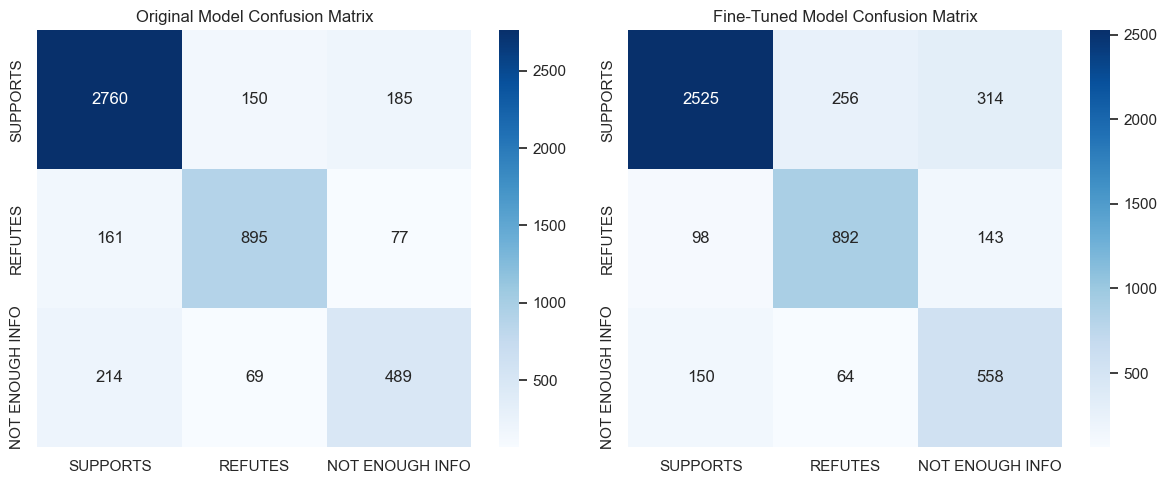


Comparison complete. See above for confusion matrices and class-specific accuracy changes.


In [147]:
#DataFrame for each model's predictions
test_df['orig_pred'] = orig_preds
test_df['ft_pred'] = ft_preds
test_df['orig_correct'] = (test_df['label_id'] == test_df['orig_pred'])
test_df['ft_correct'] = (test_df['label_id'] == test_df['ft_pred'])

#confidence columns:
test_df['orig_conf'] = [probs[p] for probs, p in zip(orig_probs, orig_preds)]
test_df['ft_conf']  = [probs[p] for probs, p in zip(ft_probs, ft_preds)]

#Compare accuracy by class
for class_id, class_name in id_to_label.items():
    orig_class_acc = test_df[test_df['label_id'] == class_id]['orig_correct'].mean()
    ft_class_acc   = test_df[test_df['label_id'] == class_id]['ft_correct'].mean()
    change = (ft_class_acc - orig_class_acc) * 100
    print(f"{class_name}: Original={orig_class_acc:.4f}, Fine-tuned={ft_class_acc:.4f} (Change={change:.2f}%)")

#confusion matrix 
orig_cm = confusion_matrix(test_df['label_id'], test_df['orig_pred'])
ft_cm   = confusion_matrix(test_df['label_id'], test_df['ft_pred'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(orig_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=id_to_label.values(), yticklabels=id_to_label.values())
plt.title("Original Model Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(ft_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=id_to_label.values(), yticklabels=id_to_label.values())
plt.title("Fine-Tuned Model Confusion Matrix")
plt.tight_layout()
plt.show()

print("\nComparison complete. See above for confusion matrices and class-specific accuracy changes.")


---

## 7. Explainability with LIME 

### 7.1 Setup & Imports

In [215]:
from IPython.display import display, HTML
from wordcloud import WordCloud
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific matplotlib/seaborn warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Passing `palette` without assigning `hue`")

# LIME
import lime
from lime.lime_text import LimeTextExplainer

# Example label maps
id_to_label = {
    0: "SUPPORTED",
    1: "REFUTED",
    2: "NOT ENOUGH INFO"
}

label_to_id = {v: k for k, v in id_to_label.items()}

print("Explainability environment ready.")

Explainability environment ready.


### 7.2 Explanation Functions

In [217]:
def predict_proba(text_list):
    """
    Given a list of input texts, tokenize them, run through your model,
    and return probabilities.
    """
    encodings = tokenizer(
        text_list,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    return probs

# Create a LimeTextExplainer with class names for display
explainer = LimeTextExplainer(class_names=list(id_to_label.values()))

def explain_prediction(text, num_features=5):
    """
    Explains a single text (claim) with LIME. Returns a dict of:
    - text
    - explanation object
    - pred_label
    - confidence
    - probabilities
    """
    # LIME explanation
    exp = explainer.explain_instance(
        text,
        predict_proba,
        num_features=num_features,
        num_samples=100
    )
    
    # Model prediction
    proba = predict_proba([text])[0]
    pred_idx = proba.argmax()
    pred_label = id_to_label[pred_idx]
    confidence = proba.max()
    
    return {
        'text': text,
        'explanation': exp,
        'pred_label': pred_label,
        'confidence': confidence,
        'probabilities': proba
    }

def visualize_explanation(explanation, title=None, figsize=(10, 6)):
    """
    Visualize the LIME explanation as a bar plot of feature weights.
    """
    try:
        # Convert predicted label string to integer class index
        pred_label = explanation['pred_label']
        if pred_label in label_to_id:
            pred_class_idx = label_to_id[pred_label]
        else:
            print(f"Warning: Label '{pred_label}' not found in label_to_id. Using default class 0.")
            pred_class_idx = 0
        
        # Extract feature weights for that class
        exp_list = explanation['explanation'].as_list(pred_class_idx)
        
        # If we get an empty list, try using class 0 as a fallback
        if not exp_list and pred_class_idx != 0:
            print(f"Warning: No explanations found for class {pred_class_idx}. Trying class 0 instead.")
            exp_list = explanation['explanation'].as_list(0)
            
        # Create DataFrame
        exp_df = pd.DataFrame(exp_list, columns=['feature', 'weight'])
        
        if not exp_df.empty:
            exp_df = exp_df.sort_values('weight', ascending=False)
            
            # Create colors for the bars
            colors = ['green' if w > 0 else 'red' for w in exp_df['weight']]
            
            # Create a new Figure for this plot
            fig, ax = plt.subplots(figsize=figsize)
            
            # Plot using matplotlib directly to avoid seaborn warnings
            bars = ax.barh(y=exp_df['feature'], width=exp_df['weight'], color=colors)
            
            # Set labels and title
            ax.set_xlabel('weight')
            ax.set_ylabel('feature')
            
            if not title:
                title = f"Explanation for '{pred_label}' (Confidence: {explanation['confidence']:.4f})"
            ax.set_title(title)
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: No features to display for explanation.")
    except Exception as e:
        print(f"Error during visualization: {e}")
        # Try a simpler fallback visualization
        try:
            explanation['explanation'].show_in_notebook(pred_class_idx)
        except:
            print("Could not visualize explanation. Please check your LIME implementation.")

def create_wordcloud(explanation):
    """
    Create a word cloud of LIME feature importances (absolute value).
    """
    try:
        # Convert predicted label string to integer class index
        pred_label = explanation['pred_label']
        if pred_label in label_to_id:
            pred_class_idx = label_to_id[pred_label]
        else:
            print(f"Warning: Label '{pred_label}' not found in label_to_id. Using default class 0.")
            pred_class_idx = 0
        
        # Get feature weights with error handling
        try:
            exp_list = explanation['explanation'].as_list(pred_class_idx)
            if not exp_list:
                print("No features found for word cloud generation.")
                return
                
            word_weights = {feat: abs(weight) for feat, weight in exp_list}
            
            # Generate wordcloud
            wc = WordCloud(background_color='white', max_words=50, width=800, height=400, colormap='viridis')
            wc.generate_from_frequencies(word_weights)
            
            plt.figure(figsize=(10, 5))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error generating word cloud: {e}")
    except Exception as e:
        print(f"Error importing libraries for word cloud: {e}")

print("Explanation functions defined.")

Explanation functions defined.


### 7.3 Demo/Usage


===== Processing claim 1/3: 'Barack Obama was the first African American president of the United States.' =====

Claim: Barack Obama was the first African American president of the United States.
Predicted Label: REFUTED (Confidence: 0.4490)


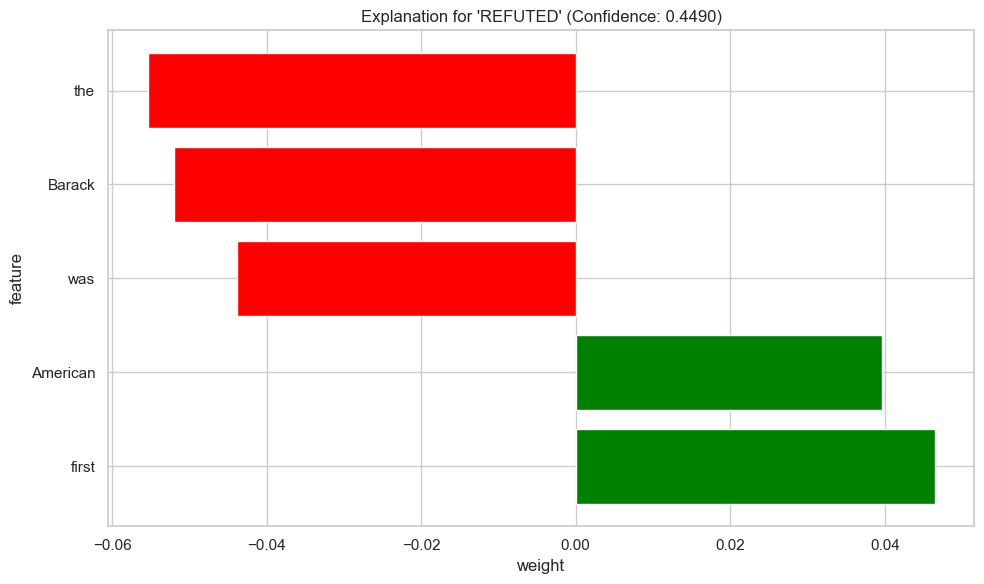

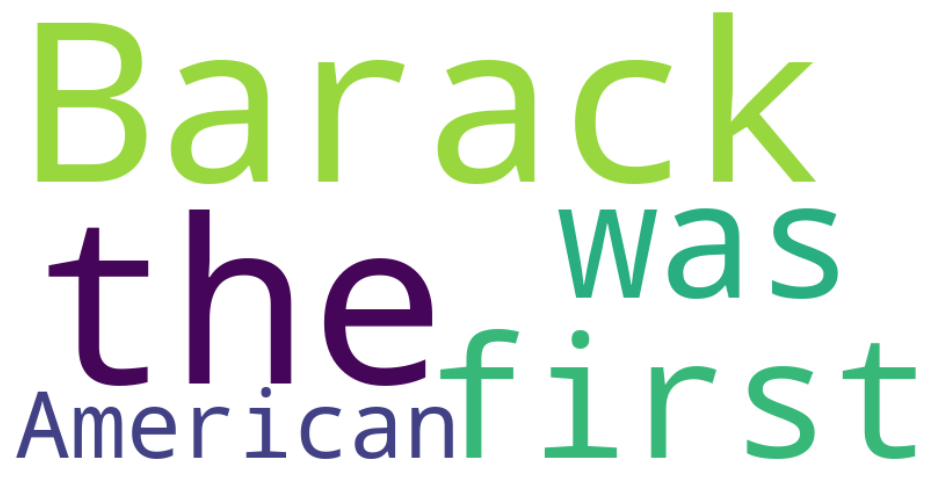




===== Processing claim 2/3: 'Paris is located in Europe.' =====

Claim: Paris is located in Europe.
Predicted Label: SUPPORTED (Confidence: 0.4729)
Error during visualization: 0
Could not visualize explanation. Please check your LIME implementation.
Error generating word cloud: 0



===== Processing claim 3/3: 'The moon is made of cheese.' =====

Claim: The moon is made of cheese.
Predicted Label: REFUTED (Confidence: 0.8483)


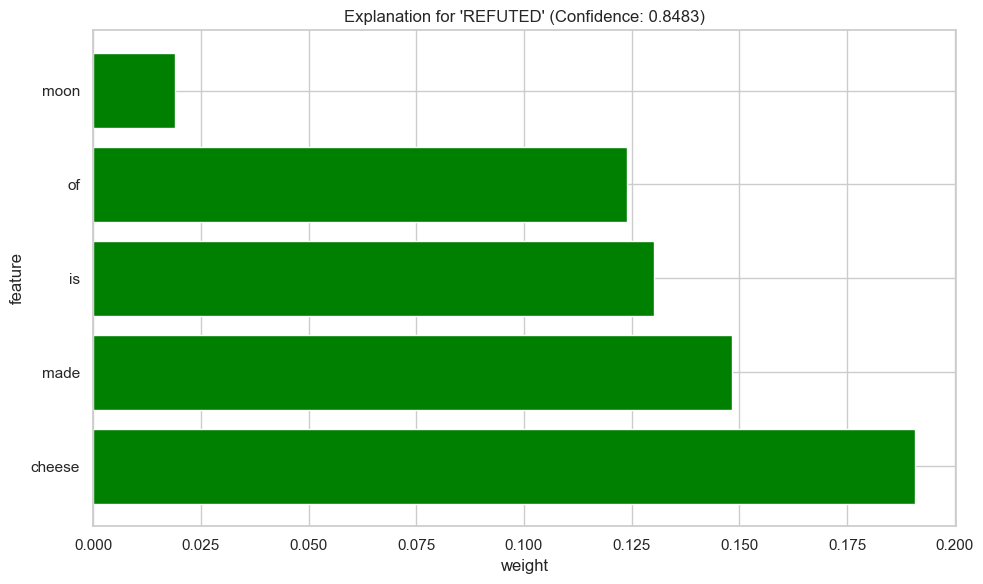

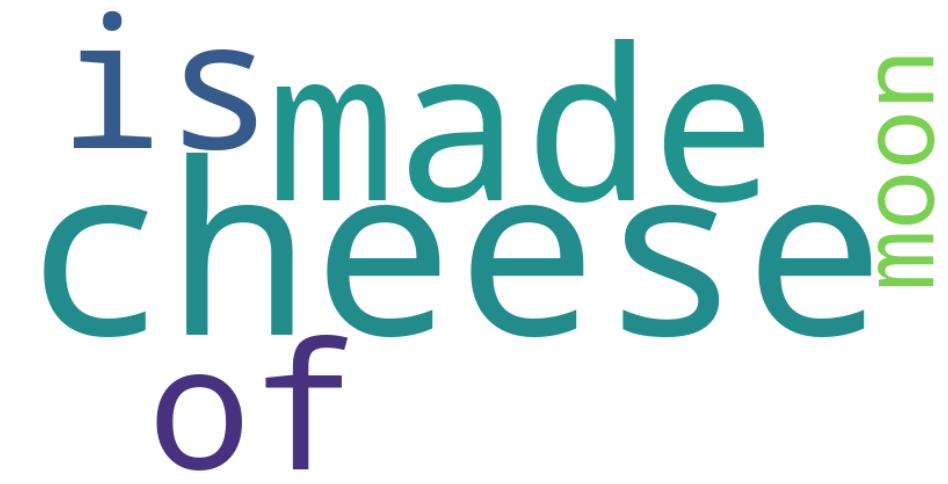

In [219]:
def explain_and_visualize_claim(claim):
    """
    Predict with LIME, then visualize the explanation
    and optionally show a word cloud of features.
    """
    try:
        # Get explanation
        explanation = explain_prediction(claim)
        print(f"Claim: {claim}")
        print(f"Predicted Label: {explanation['pred_label']} (Confidence: {explanation['confidence']:.4f})")
        
        # Bar-plot explanation
        visualize_explanation(explanation)
        
        # Word Cloud (optional)
        create_wordcloud(explanation)
        
        return explanation
    except Exception as e:
        print(f"Error processing claim: '{claim}'")
        print(f"Error details: {str(e)}")
        return None

# Example usage
example_claims = [
    "Barack Obama was the first African American president of the United States.",
    "Paris is located in Europe.", 
    "The moon is made of cheese."
]

# Process each claim individually with clear separation
for i, claim in enumerate(example_claims):
    print(f"\n===== Processing claim {i+1}/{len(example_claims)}: '{claim}' =====\n")
    try:
        explain_and_visualize_claim(claim)
    except Exception as e:
        print(f"Failed to process claim. Error: {str(e)}")
    print("\n" + "="*80 + "\n")


### 7.4 Bias Evaluation 

In [221]:
def evaluate_model_bias():
    """
    Evaluates the model for potential biases in fact classification.
    """
    print("\n===== Evaluating Model Bias on Factual Statements =====\n")
    
    # True factual claims that should be SUPPORTED
    factual_claims = [
        "Barack Obama was the first African American president of the United States.",
        "Paris is located in Europe.",
        "Water is composed of hydrogen and oxygen.",
        "The Earth orbits around the Sun.",
        "Australia is a country and a continent."
    ]
    
    # False claims that should be REFUTED
    false_claims = [
        "The moon is made of cheese.",
        "The Earth is flat.",
        "Humans have six fingers on each hand.",
        "The Atlantic Ocean is located between Europe and China.",
        "Cats are a type of fish."
    ]
    
    results = {"Factual Claims": [], "False Claims": []}
    
    print("Testing factual claims that should be classified as SUPPORTED:")
    for claim in factual_claims:
        proba = predict_proba([claim])[0]
        pred_idx = proba.argmax()
        pred_label = id_to_label[pred_idx]
        confidence = proba.max()
        results["Factual Claims"].append({
            "claim": claim,
            "predicted": pred_label,
            "confidence": confidence,
            "correct": pred_label == "SUPPORTED"
        })
        print(f"  • {claim}")
        print(f"    → Predicted: {pred_label} (Confidence: {confidence:.4f})")
        print(f"    → {'✓ Correct' if pred_label == 'SUPPORTED' else '✗ Incorrect'}")
    
    print("\nTesting false claims that should be classified as REFUTED:")
    for claim in false_claims:
        proba = predict_proba([claim])[0]
        pred_idx = proba.argmax()
        pred_label = id_to_label[pred_idx]
        confidence = proba.max()
        results["False Claims"].append({
            "claim": claim,
            "predicted": pred_label,
            "confidence": confidence,
            "correct": pred_label == "REFUTED"
        })
        print(f"  • {claim}")
        print(f"    → Predicted: {pred_label} (Confidence: {confidence:.4f})")
        print(f"    → {'✓ Correct' if pred_label == 'REFUTED' else '✗ Incorrect'}")
    
    # Calculate accuracy statistics
    factual_accuracy = sum(1 for r in results["Factual Claims"] if r["correct"]) / len(results["Factual Claims"])
    false_accuracy = sum(1 for r in results["False Claims"] if r["correct"]) / len(results["False Claims"])
    overall_accuracy = (sum(1 for r in results["Factual Claims"] if r["correct"]) + 
                        sum(1 for r in results["False Claims"] if r["correct"])) / (
                        len(results["Factual Claims"]) + len(results["False Claims"]))
    
    print("\nAccuracy Summary:")
    print(f"  • Factual Claims (SUPPORTED): {factual_accuracy:.2%}")
    print(f"  • False Claims (REFUTED): {false_accuracy:.2%}")
    print(f"  • Overall Accuracy: {overall_accuracy:.2%}")
    
    # Check for bias
    if factual_accuracy < false_accuracy:
        print("\nPotential Model Bias Detected: The model is better at identifying false claims than recognizing factual statements.")
        print("This suggests a bias toward classifying claims as REFUTED.")
    elif factual_accuracy > false_accuracy:
        print("\nPotential Model Bias Detected: The model is better at identifying factual claims than recognizing false statements.")
        print("This suggests a bias toward classifying claims as SUPPORTED.")
    
    return results


evaluate_model_bias()


===== Evaluating Model Bias on Factual Statements =====

Testing factual claims that should be classified as SUPPORTED:
  • Barack Obama was the first African American president of the United States.
    → Predicted: REFUTED (Confidence: 0.4490)
    → ✗ Incorrect
  • Paris is located in Europe.
    → Predicted: SUPPORTED (Confidence: 0.4729)
    → ✓ Correct
  • Water is composed of hydrogen and oxygen.
    → Predicted: REFUTED (Confidence: 0.7368)
    → ✗ Incorrect
  • The Earth orbits around the Sun.
    → Predicted: REFUTED (Confidence: 0.5800)
    → ✗ Incorrect
  • Australia is a country and a continent.
    → Predicted: SUPPORTED (Confidence: 0.5284)
    → ✓ Correct

Testing false claims that should be classified as REFUTED:
  • The moon is made of cheese.
    → Predicted: REFUTED (Confidence: 0.8483)
    → ✓ Correct
  • The Earth is flat.
    → Predicted: REFUTED (Confidence: 0.6495)
    → ✓ Correct
  • Humans have six fingers on each hand.
    → Predicted: REFUTED (Confidence: 0

{'Factual Claims': [{'claim': 'Barack Obama was the first African American president of the United States.',
   'predicted': 'REFUTED',
   'confidence': 0.44900435,
   'correct': False},
  {'claim': 'Paris is located in Europe.',
   'predicted': 'SUPPORTED',
   'confidence': 0.47288013,
   'correct': True},
  {'claim': 'Water is composed of hydrogen and oxygen.',
   'predicted': 'REFUTED',
   'confidence': 0.73675025,
   'correct': False},
  {'claim': 'The Earth orbits around the Sun.',
   'predicted': 'REFUTED',
   'confidence': 0.5800406,
   'correct': False},
  {'claim': 'Australia is a country and a continent.',
   'predicted': 'SUPPORTED',
   'confidence': 0.5284057,
   'correct': True}],
 'False Claims': [{'claim': 'The moon is made of cheese.',
   'predicted': 'REFUTED',
   'confidence': 0.8483302,
   'correct': True},
  {'claim': 'The Earth is flat.',
   'predicted': 'REFUTED',
   'confidence': 0.6494769,
   'correct': True},
  {'claim': 'Humans have six fingers on each hand.',

### 7.5 Label Mappings

In [223]:
# Define label mappings
id_to_label = {
    0: "SUPPORTED",
    1: "REFUTED",
    2: "NOT ENOUGH INFO"
}

# Create reverse mapping for label lookup
label_to_id = {v: k for k, v in id_to_label.items()}

### 7.6 Define LIME Explanation Functions

In [225]:
def explain_prediction(text, num_features=5):
    """
    Explains a prediction with LIME. Returns a dict with text, explanation, 
    predicted label, confidence, and probabilities.
    """
    # Create explanation with LIME
    exp = explainer.explain_instance(
        text,
        predict_proba,
        num_features=num_features,
        num_samples=100
    )
    
    # Get model prediction
    proba = predict_proba([text])[0]
    pred_idx = proba.argmax()
    pred_label = id_to_label[pred_idx]
    confidence = proba.max()
    
    # Return all necessary information
    return {
        'text': text,
        'explanation': exp,
        'pred_label': pred_label,
        'confidence': confidence,
        'probabilities': proba
    }

In [227]:
def visualize_explanation(explanation, title=None, figsize=(10, 6)):
    """
    Visualize a LIME explanation as a horizontal bar plot.
    
    Args:
        explanation: Dictionary containing explanation data
        title: Optional custom title for the plot
        figsize: Figure size as (width, height) tuple
    """
    # Create figure
    plt.figure(figsize=figsize)
    
    # Get the prediction class label
    pred_label = explanation['pred_label']
    pred_class_idx = None
    exp_list = None
    
    # Try multiple approaches to get the explanation list
    for idx in [label_to_id.get(pred_label), 0, 1]:
        if idx is not None:
            try:
                exp_list = explanation['explanation'].as_list(idx)
                if exp_list:  # If we get a non-empty list, use this class
                    pred_class_idx = idx
                    break
            except:
                continue
    
    if not exp_list:
        print(f"Warning: Could not get explanation for any class. Visualization failed.")
        return
    
    # Create a dataframe for the visualization
    exp_df = pd.DataFrame(exp_list, columns=['feature', 'weight'])
    exp_df = exp_df.sort_values('weight', ascending=False)
    
    # Use direct matplotlib plotting to avoid seaborn warnings
    ax = plt.gca()
    colors = ['green' if w > 0 else 'red' for w in exp_df['weight']]
    ax.barh(y=exp_df['feature'], width=exp_df['weight'], color=colors)
    
    # Set labels
    ax.set_xlabel('weight')
    ax.set_ylabel('feature')
    
    # Set title
    if title:
        plt.title(title)
    else:
        class_shown = id_to_label.get(pred_class_idx, "Unknown")
        if class_shown != pred_label:
            plt.title(f"Showing features for class: '{class_shown}'\nActual prediction: '{pred_label}' (Confidence: {explanation['confidence']:.4f})")
        else:
            plt.title(f"Explanation for '{pred_label}' (Confidence: {explanation['confidence']:.4f})")
    
    plt.tight_layout()
    plt.show()

In [229]:
def create_wordcloud(explanation):
    """
    Create a word cloud visualization from a LIME explanation.
    
    Args:
        explanation: Dictionary containing explanation data
    """
    try:
        # Get the prediction class
        pred_label = explanation['pred_label']
        
        # Try to get the class index
        pred_class = label_to_id.get(pred_label)
        if pred_class is None:
            print(f"Warning: Label '{pred_label}' not found. Using default class 0.")
            pred_class = 0
        
        # Get explanation for the predicted class
        try:
            exp_list = explanation['explanation'].as_list(pred_class)
            if not exp_list:  # If empty, try class 0
                print(f"No features found for class {pred_class}. Trying class 0.")
                exp_list = explanation['explanation'].as_list(0)
        except:
            # If that fails, try class 1 (REFUTED)
            try:
                exp_list = explanation['explanation'].as_list(1)
            except:
                print("Could not get features for any class. Word cloud generation failed.")
                return
        
        # Create a dictionary of word weights (using absolute values)
        word_weights = {word: abs(weight) for word, weight in exp_list}
        
        if not word_weights:
            print("No features to display in word cloud.")
            return
        
        # Create word cloud
        wc = WordCloud(
            background_color='white',
            max_words=50,
            width=800,
            height=400,
            colormap='viridis'
        )
        
        # Generate from frequencies
        wc.generate_from_frequencies(word_weights)
        
        # Plot
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"Error generating word cloud: {e}")

In [231]:
def analyze_explanations_by_class(explanations):
    """
    Analyze LIME explanations by class to find patterns in feature importance.
    
    Args:
        explanations: List of explanation dictionaries
        
    Returns:
        Dictionary with insights for each class
    """
    # Initialize data structures
    class_features = {class_name: [] for class_name in id_to_label.values()}
    class_insights = {}
    
    for exp in explanations:
        pred_label = exp['pred_label']
        pred_class = label_to_id.get(pred_label, 0)  # Default to 0 if not found
        
        # Get features for the predicted class
        try:
            features = exp['explanation'].as_list(pred_class)
            class_features[pred_label].extend(features)
        except:
            continue  # Skip if no features found
    
    # Process features for each class
    for class_name, features in class_features.items():
        if not features:
            continue
            
        # Create a dataframe of features
        feat_df = pd.DataFrame(features, columns=['feature', 'weight'])
        
        # Get positive and negative features
        pos_features = feat_df[feat_df['weight'] > 0].sort_values('weight', ascending=False)
        neg_features = feat_df[feat_df['weight'] < 0].sort_values('weight')
        
        # Count feature occurrences
        pos_counts = pos_features['feature'].value_counts()
        neg_counts = neg_features['feature'].value_counts()
        
        # Get average weights for common features
        pos_avg = pos_features.groupby('feature')['weight'].mean().sort_values(ascending=False)
        neg_avg = neg_features.groupby('feature')['weight'].mean().sort_values()
        
        # Store insights
        class_insights[class_name] = {
            'positive_features': pos_avg.to_dict(),
            'negative_features': neg_avg.to_dict(),
            'positive_counts': pos_counts.to_dict(),
            'negative_counts': neg_counts.to_dict()
        }
    
    return class_insights

In [233]:
def create_feature_wordclouds(class_insights):
    """
    Create word clouds visualizing positive and negative features for each class.
    
    Args:
        class_insights: Dictionary with class insights from analyze_explanations_by_class
    """
    # Skip if no insights
    if not class_insights:
        print("No insights available for visualization.")
        return
    
    for class_name, insights in class_insights.items():
        # Skip if no features
        if not insights.get('positive_features') and not insights.get('negative_features'):
            continue
            
        # Set up subplot layout
        fig = plt.figure(figsize=(16, 8))
        
        # Create word cloud of positive features
        if insights.get('positive_features'):
            plt.subplot(1, 2, 1)
            wc_pos = WordCloud(
                background_color='white',
                max_words=50,
                width=800,
                height=400,
                colormap='Greens'
            )
            wc_pos.generate_from_frequencies(insights['positive_features'])
            
            plt.imshow(wc_pos, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"{class_name}: Supporting Features")
        
        # Create word cloud of negative features
        if insights.get('negative_features'):
            plt.subplot(1, 2, 2)
            # Use absolute values for weights
            neg_features = {k: abs(v) for k, v in insights['negative_features'].items()}
            
            wc_neg = WordCloud(
                background_color='white',
                max_words=50,
                width=800,
                height=400,
                colormap='Reds'
            )
            wc_neg.generate_from_frequencies(neg_features)
            
            plt.imshow(wc_neg, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"{class_name}: Opposing Features")
        
        plt.tight_layout()
        plt.show()

### 7.7 Function to explain new claims for the demo system

In [244]:
def explain_claim(claim, show_html=False):
    """
    Analyze a new claim and provide a complete explanation with visualizations.
    
    Args:
        claim: Text of the claim to analyze
        show_html: Whether to display HTML explanation
        
    Returns:
        Explanation dictionary
    """
    # Get explanation
    explanation = explain_prediction(claim)
    
    # Show results
    print(f"Claim: {claim}")
    print(f"Prediction: {explanation['pred_label']} (Confidence: {explanation['confidence']:.4f})")
    
    # Show probabilities for all classes
    probabilities = explanation['probabilities']
    prob_str = ", ".join([f"{id_to_label[i]}={prob:.4f}" for i, prob in enumerate(probabilities)])
    print(f"Probabilities: {prob_str}")
    
    # Visualize
    visualize_explanation(explanation)
    create_wordcloud(explanation)
    
    # Show HTML if requested
    if show_html:
        try:
            html = explanation['explanation'].as_html()
            display(HTML(html))
        except Exception as e:
            print(f"Could not generate HTML: {e}")
    
    return explanation

### 7.8 Demo with Examples

Demonstrating explanation system with example claims:

===== Example 1/3 =====
Claim: Barack Obama was the first African American president of the United States.
Prediction: REFUTED (Confidence: 0.4490)
Probabilities: SUPPORTED=0.3919, REFUTED=0.4490, NOT ENOUGH INFO=0.1590


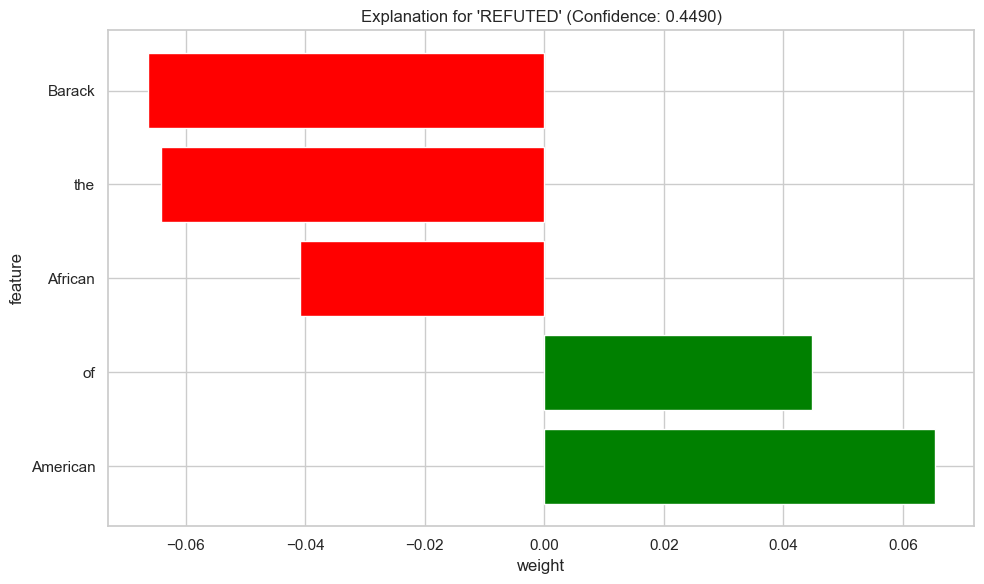

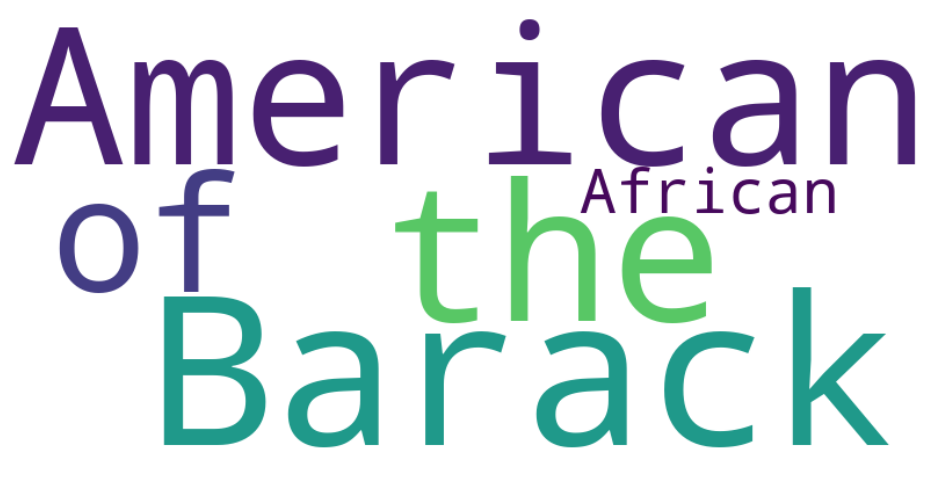


===== Example 2/3 =====
Claim: Paris is located in Europe.
Prediction: SUPPORTED (Confidence: 0.4729)
Probabilities: SUPPORTED=0.4729, REFUTED=0.4119, NOT ENOUGH INFO=0.1152


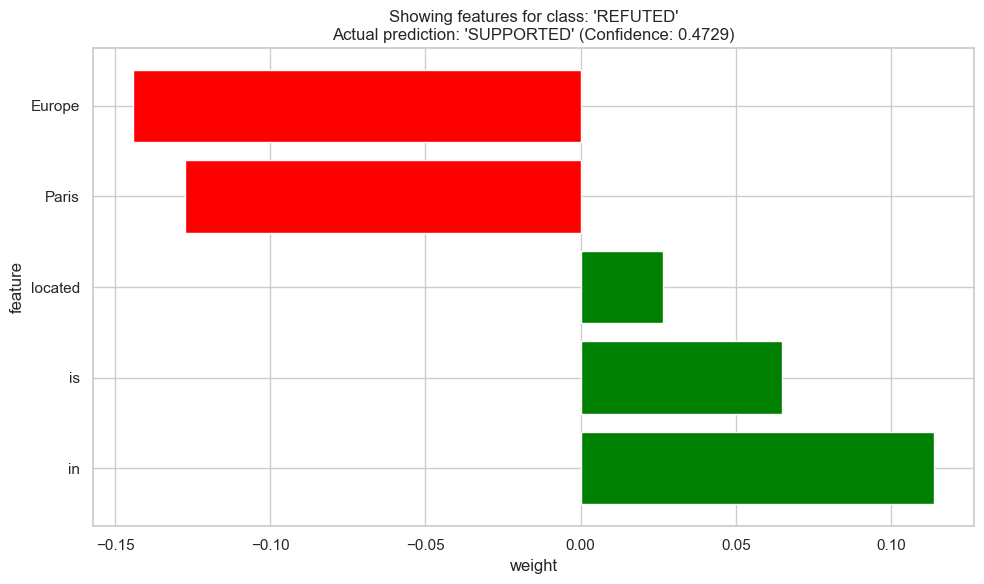

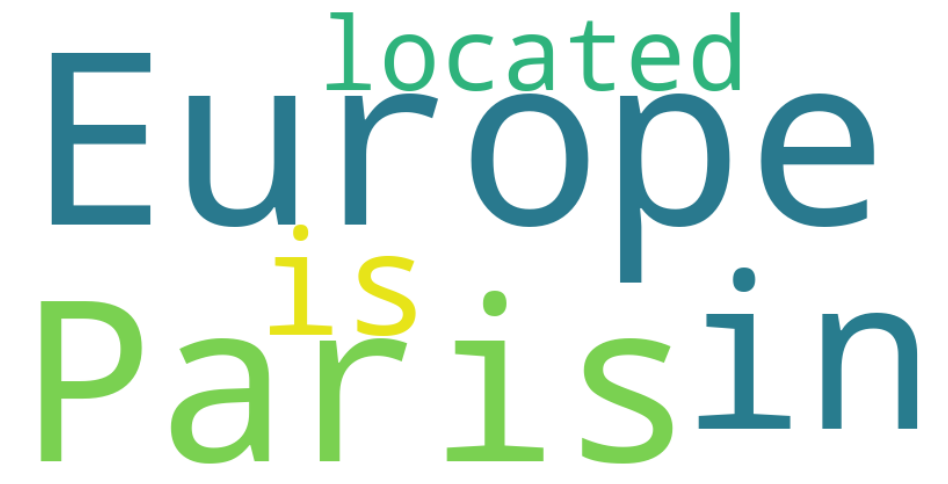


===== Example 3/3 =====
Claim: The Harry Potter series was written by an author.
Prediction: SUPPORTED (Confidence: 0.4217)
Probabilities: SUPPORTED=0.4217, REFUTED=0.4055, NOT ENOUGH INFO=0.1727


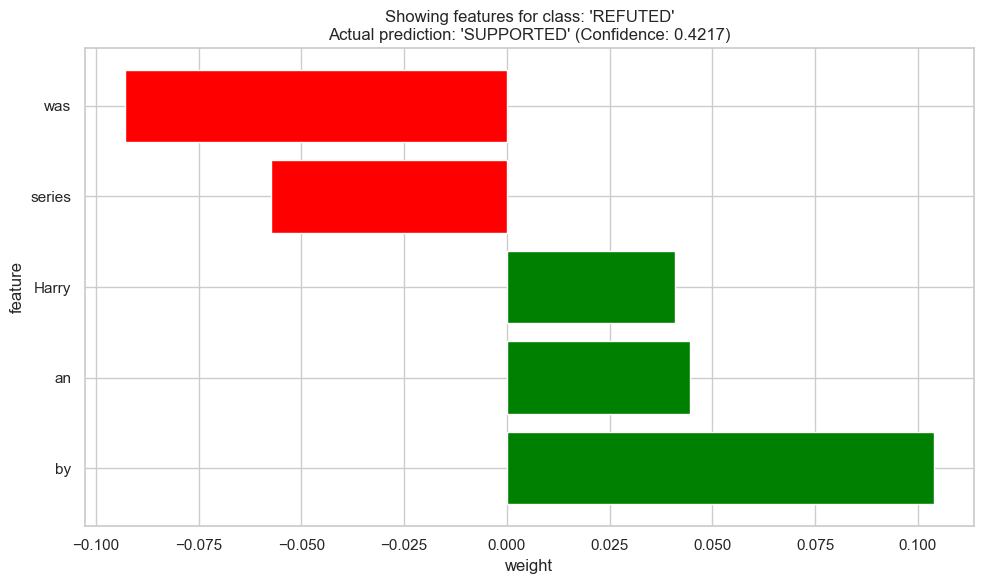

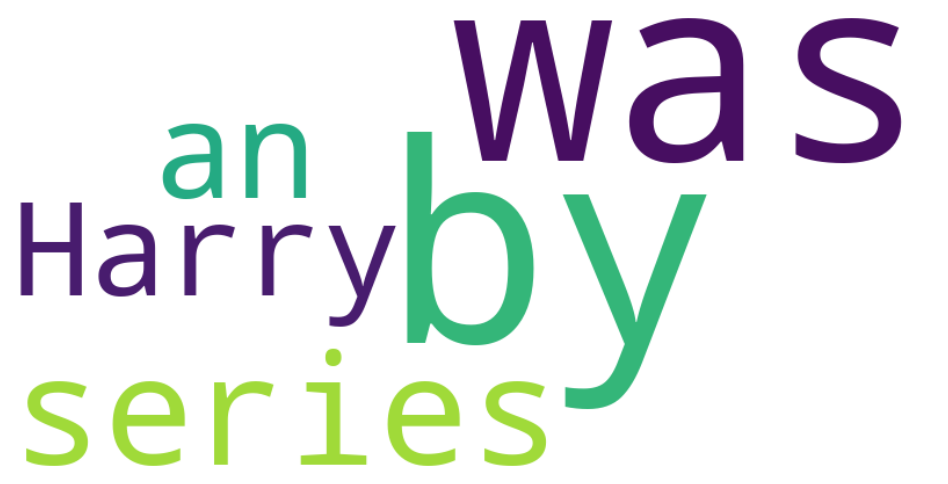


===== Class Analysis =====


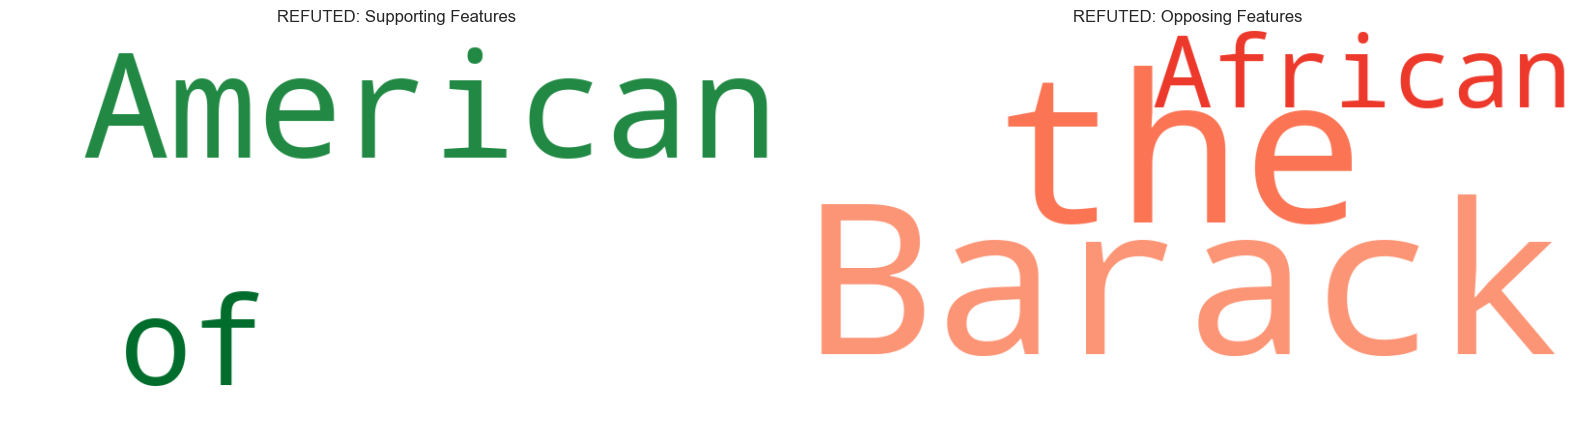

In [239]:
def run_demo_examples():
    """Run the demonstration with example claims."""
    print("Demonstrating explanation system with example claims:")
    
    example_claims = [
        "Barack Obama was the first African American president of the United States.",
        "Paris is located in Europe.",
        "The Harry Potter series was written by an author."
    ]
    
    # Collect explanations for analysis
    explanations = []
    
    # Process each claim
    for i, claim in enumerate(example_claims):
        print(f"\n===== Example {i+1}/{len(example_claims)} =====")
        explanation = explain_claim(claim)
        explanations.append(explanation)
        print("="*50)
    
    # Analyze patterns across classes
    print("\n===== Class Analysis =====")
    insights = analyze_explanations_by_class(explanations)
    create_feature_wordclouds(insights)
    
    return explanations, insights

# Uncomment to run the demo
explanations, insights = run_demo_examples()

## 8 Optimization and Inference Time Measurement

In [247]:
import time
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# 1. Load the FEVER dataset (adjust filename if needed)
label_map = {'SUPPORTS': 0, 'REFUTES': 1, 'NOT ENOUGH INFO': 2}
df_fever = pd.read_csv("clean_fever_dataset.csv")
df_fever['label_id'] = df_fever['label'].map(label_map)

# 2. Split into train/val/test
train_df, temp_df = train_test_split(df_fever, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Test set size: {len(test_df)}")
print(test_df.head())

# 3. Prepare tokenizer & model
#    Replace 'distilbert-base-uncased' with the directory containing your saved model if needed.
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# 4. Create a PyTorch DataLoader for the test set
text_column = 'processed_claim'  # or 'original_claim' if you prefer
texts = test_df[text_column].tolist()
labels = test_df['label_id'].tolist()

encodings = tokenizer(
    texts,
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='pt'
)
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
labels_tensor = torch.tensor(labels)

test_dataset = TensorDataset(input_ids, attention_mask, labels_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=16)

print("Data & model setup complete.")


Test set size: 5000
                                          original_claim  \
25056  The Republic of Zambia is bordered to the sout...   
30334          There is a singer named Miranda Cosgrove.   
17962   Chris Evans worked for Piccadilly Radio in 2009.   
39588                     Marilyn Monroe is still alive.   
34107  Nelson Mandela introduced expansions to video ...   

                                      processed_claim            label  \
25056         republic zambia bordered south zimbabwe         SUPPORTS   
30334                   singer named miranda cosgrove         SUPPORTS   
17962        chris evans worked piccadilly radio 2009  NOT ENOUGH INFO   
39588                      marilyn monroe still alive          REFUTES   
34107  nelson mandela introduced expansion video game  NOT ENOUGH INFO   

           id  label_id  
25056  191685         0  
30334   87377         0  
17962   42006         2  
39588    5643         1  
34107   58048         2  


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Data & model setup complete.


In [248]:
import time

print("Measuring inference time on test set...")

# Ensure model is in eval mode
model.eval()

start_time = time.time()

# Generate predictions (not storing them if you only want timing)
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, _ = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # logits = outputs.logits
        # preds = torch.argmax(logits, dim=1).cpu().numpy()  # if you need them

end_time = time.time()
baseline_inference_time = end_time - start_time

print(f"Baseline Inference Time: {baseline_inference_time:.2f} seconds")


Measuring inference time on test set...
Baseline Inference Time: 71.19 seconds
